In [133]:
import numpy as np, matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from typing import Callable
from numpy.typing import NDArray

In [ ]:
# ----- INITIALISE -----
R_MAX = 1
R_MIN = 0.1
R_RES = 2500
EPS = 1e-12
NUM_BINS_SMAK = 400
SQRT_R_MAX = np.sqrt(R_MAX)
SQRT_R_MIN = np.sqrt(R_MIN)
U_MAX = 1/SQRT_R_MIN

In [135]:
# ----- FUNCTION DEFINITIONS -----

def get_intens(r: float, theta: float, a: float = 1.5) -> float:
    """
    Returns the brightness on the accretion disk at a given radius
    according to the inverse power law r^(-a)
    """
    return r**(-a)

def get_grids(
    intens_func: Callable[[float, float, float], float] = get_intens,   # function(r, theta, a)
    a: float = 1.5,
    num_radial: int = 400,
    num_theta: int = 8192,
    radial_spacing: str = "log"   # "log" or "linear"
):
    """
    Returns a tuple of ndarrays: `(r_grid, theta_grid, area_weights, vel_grid, area_flux_grid)`
    by sampling the disk in polar coordinates and multiplying the intensities by the area of
    each coordinate.
    """
    # --- radial edges & centres ---
    if radial_spacing == "log":
        r_edges = np.geomspace(R_MIN, R_MAX, num_radial + 1)    # num_radial points spaced logarithmically from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges, is_log=True)
    elif radial_spacing == "linear":
        r_edges = np.linspace(R_MIN, R_MAX, num_radial + 1)     # num_radial points spaced linearly from R_MIN - R_MAX
        r_centres = get_bin_centres(r_edges)
    else:
        raise Exception("invalid radial_spacing argument")
    # array of distances between r_edges of length num_radial
    dr = r_edges[1:] - r_edges[:-1]

    # theta edges & centres
    theta_edges = np.linspace(0.0, 2.0 * np.pi, num_theta + 1)
    theta_centres = get_bin_centres(theta_edges)
    dtheta = theta_edges[1] - theta_edges[0] # all equally spaced so 1st - 0th = scalar is fine

    # create 2D grid (theta x r)
    theta_grid, r_grid = np.meshgrid(theta_centres, r_centres, indexing="ij")

    # area weight for each cell: r * dr * dtheta (from Jacobian)
    area_weights = r_grid * dr * dtheta

    # evaluate intensity and velocity on the grid
    intens_grid = intens_func(r_grid, theta_grid, a)
    area_flux_grid = intens_grid * area_weights
    vel_grid = np.cos(theta_grid) / np.sqrt(r_grid)

    return (r_grid, theta_grid, area_weights, vel_grid, area_flux_grid)

#TODO: adjust to work for polar coordinates
def plot_2d_profile(
    values: np.ndarray[np.float64], 
    is_polar: bool = True, *,
    colourmap: str = "viridis",
    title: str = "Profile",
    x_label: str = "x", y_label: str = "y",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "custom"
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
) -> None:
    """
    Plots a 2D numpy array of values on a grid with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")

    plt.figure(figsize = figure_size)

    img = plt.imshow(
        values,
        origin="lower",
        cmap=colourmap,
        aspect="equal",
        vmin=vmin_plot, vmax=vmax_plot
    )

    cbar = plt.colorbar(img)
    cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

def get_hist_vals(
    vel_grid: np.ndarray[np.float64],
    area_flux_grid: np.ndarray[np.float64], *,
    num_bins: int = 1200,
    normalise: bool = True,
    smooth_sigma: float | None = None
) -> tuple[np.ndarray[np.float64], np.ndarray[np.float64]]:
    """
    Flattens and places valid `area_flux_grid` values into `num_bins` bins
    using numpy\'s `histogram` function. Returns the tuple
    `(u_bin_centres, hist_brightness_vals)`.
    """
    u_flat = vel_grid.ravel()
    a_flux_flat = area_flux_grid.ravel()

    # remove NaNs/Infs and (unnecessary) zero-weight samples
    finite_mask = np.isfinite(u_flat) & np.isfinite(a_flux_flat) & (a_flux_flat > 0)
    u_flat = u_flat[finite_mask]
    a_flux_flat = a_flux_flat[finite_mask]

    # --- histogram into uniform velocity bins that scale with R_MIN ---
    u_bin_edges = np.linspace(-U_MAX, U_MAX, num_bins + 1)
    hist_brightness_vals, _ = np.histogram(u_flat, bins=u_bin_edges, weights=a_flux_flat) #returns bin edges as well but that's not needed
    u_bin_centres = get_bin_centres(u_bin_edges)

    if normalise and np.max(hist_brightness_vals) > 0:
        hist_brightness_vals /= np.max(hist_brightness_vals)

    if smooth_sigma is not None and smooth_sigma > 0:
        hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=smooth_sigma)

    return u_bin_centres, hist_brightness_vals

def plot_spectrum_list(
    a_vals: np.ndarray[np.float64] = np.arange(0, 2.51, 0.5),
    plot_smak: bool = False,
    sigma: float = None, *,
    xlim: tuple[float, float] = (-5, 5),
    xlabel="Relative Speed",
    ylabel="Brightness",
    title="Light Spectrum",
    figure_size: tuple[float, float] = (8, 5),
    grid_alpha: float = 0.3
) -> None:
    """
    Plots the model intensity over a range of u values (speeds/wavelengths) for a disk with
    brightness decsribed by :func:`get_intens` over a range of `a_vals`. Optionally plots
    Smak analytical solitions on top if `plot_smak` is `True`.
    """
    if sigma is not None and sigma <= 0:
        raise Exception("Invalid sigma argument")

    if isinstance(a_vals, (int, float)):
        a_vals = np.array([a_vals])

    if a_vals is None or len(a_vals) == 0:
        return


    plt.figure(figsize=figure_size)

    for a in a_vals:
        # radial sampling
        _, _, _, vel_grid, area_flux_grid = get_grids(a=a)
        u_bin_centres, hist_brightness_vals = get_hist_vals(vel_grid, area_flux_grid)


        if sigma is not None:
            hist_brightness_vals = gaussian_filter1d(hist_brightness_vals, sigma=sigma)

        model_label = f"a = {a}"

        if plot_smak:
            smak_u_vals = np.linspace(-U_MAX, U_MAX, NUM_BINS_SMAK)
            smak_brightness = smak_F(smak_u_vals, a)
            if sigma is not None:
                smak_brightness = gaussian_filter1d(smak_brightness, sigma=sigma)
            
            model_label = f"Model (a={a})"
            smak_label = f"Smak (a={a})"

            plt.plot(
                smak_u_vals, smak_brightness,
                linestyle = "-", label=smak_label
            )

        plt.plot(
            u_bin_centres, hist_brightness_vals,
            linestyle = '--', label = model_label
        )

    plt.xlabel(f"{xlabel}")
    plt.ylabel(ylabel)
    smoothtag = f" (Gaussian smoothed, sigma={sigma:g})" if (sigma is not None and sigma > 0) else ""
    plt.title(title + smoothtag)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ----- SMAK FUNCTIONS -----

def smak_F(u_vals: np.ndarray[np.float64], a: float) -> np.ndarray[np.float64]:
    """
    Returns a numpy array of intensity values F(u) associated with the array
    of `u_vals` given, according to Smak\'s analytical solution.
    """
    intensities = np.full_like(u_vals, np.nan, float)   # make array of NaNs

    exp = 2*a - 5

    for j, u in enumerate(u_vals):
        # guard the singular prefactor at u=0 if exponent < 0
        if abs(u) < EPS and exp < 0:
            intensities[j] = np.nan
            continue

        x_z = np.clip(u, -1.0, 1.0)
        x_1 = np.clip(u * SQRT_R_MIN, -1.0, 1.0)

        upper = smak_I(a, x_z)
        lower = smak_I(a, x_1)
        diff  = upper - lower

        intensities[j] = (u**exp) * diff

    # normalise robustly (optional)
    finite = np.isfinite(intensities)
    norm_intens = intensities
    if finite.any(): # check if any intensities are finite
        amp = np.nanmax(np.abs(intensities))
        if (np.isfinite(amp) and amp > 0):
            norm_intens = intensities / amp

    return norm_intens

def smak_I(a: float, x: float) -> float:
    """
    Helper function for :func:`smak_F`.
    """
    result = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            result = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            result = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            result = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            result = -s
        elif a == 2.0:
            result = np.arcsin(x)
        elif a == 2.5:
            result = np.log(abs((1.0 - s) / x)) if abs(x) > EPS else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return result


# ----- HELPER FUNCTIONS -----

def get_bin_centres(edges: np.ndarray, is_log: bool = False) -> np.ndarray:
    if is_log:
        # geometric-centre for each bin in log space
        return np.sqrt(edges[:-1] * edges[1:])
    # bin centres for linearly spaced edges
    return (edges[:-1] + edges[1:]) / 2

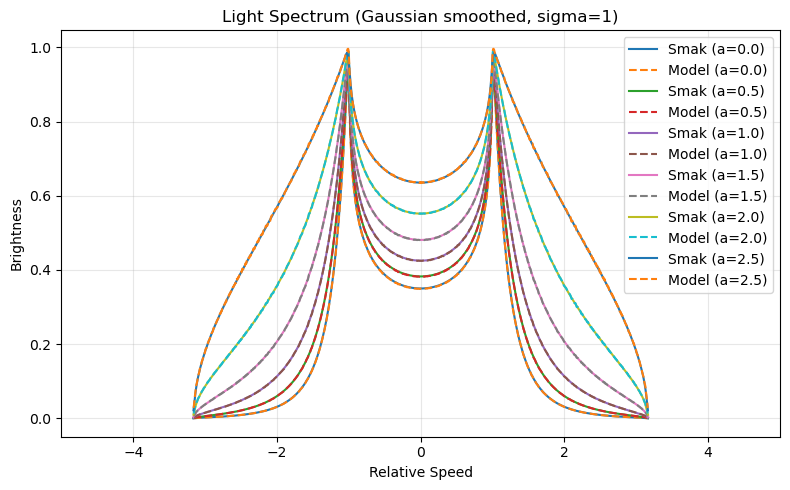

In [137]:
# ----- TESTING -----

sigma = 1
plot_smak = R_MAX == 1
title = "Light Spectrum"
title += " (raw)" if sigma is None else ""

plot_spectrum_list(title=title, plot_smak=plot_smak, sigma=sigma)